# Machine Learning Engineer Nanodegree

## Project: predicting Air BnB prices in New York City

### Getting started
In this project, we will look at and evaluate the predictive power of a model. We will train the model on the data of AirBnb in New York City. Considering that the model will have a good fit on the training and good performance on the test set, we will use that model to predict the prices.
For someone looking to rent his home on AirBnb, this model will be invaluable to determine whether the location can be profitable or not.

This proejct aims at using machine learning techniques to predict the prices of AirBnb listings.

### Importing packages

In [0]:
# Importing required libraries

!pip install geopandas
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data set used is available on *insideairbnb.com*. It has 16 features and a little less than 50,600 lines. The data has been scrapped on a particular day. We have thus no possiblity to get the evolution of prices, the eventual rebates and decreases in prices.
The dataset contains 106 features. A lot of them are numerical and dates, also some are textual.
One issue that has been raised using this dataset in the price column. Indeed, it is the listed price and not the average price over the year.





### First look at the data

In [0]:
# Importing the data
df = pd.read_csv('/content/drive/My Drive/listings.csv')

print(len(df))
print(len(df.columns))

50599
106


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Looking at the columns list, we will start by deleting a number of columns that will not be necessary for a further study of the dataset.

In [0]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 
                'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = df.drop(cols_to_drop, axis=1)

Checking if we have a lot of N/A values in the dataset to evaluate the amount of pre processing to do

In [0]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                        563
host_response_time                              17658
host_response_rate                              17658
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               10220
Length: 79, dtype: int64

Dropping another columns regarding the previous cell

In [0]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

In [0]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

Before we delete the latitude and longitude columns, we save them in a separate dataframe for plotting later.

In [0]:
lat_long = df[['latitude', 'longitude']]

In [0]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [0]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

Considering some columns to be t/f instead of True/False, we change that and we plot them to look at the distribution.

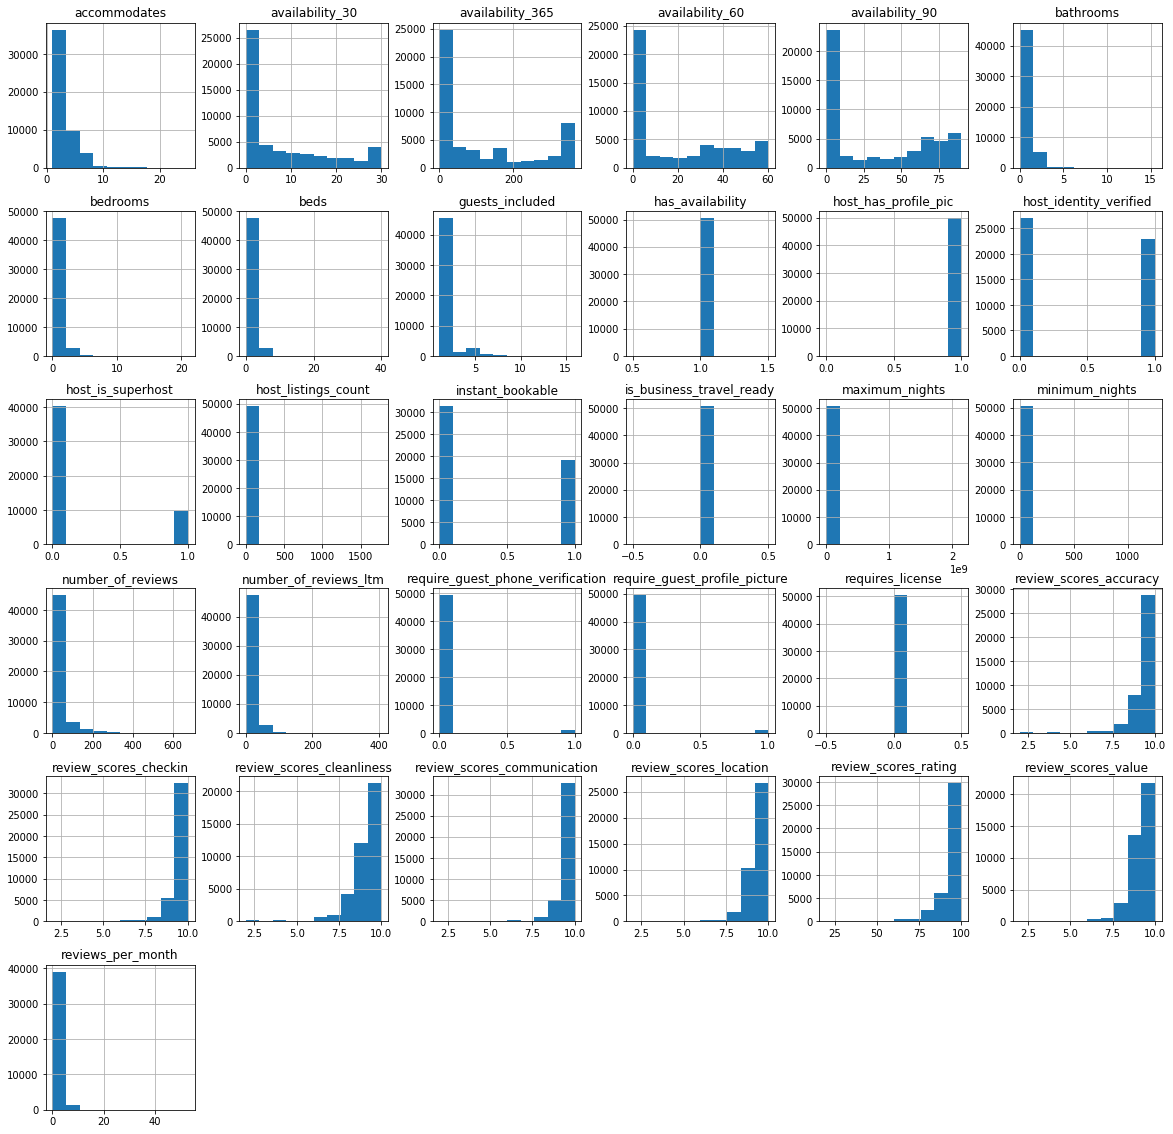

In [0]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

We delete some more columns as they won't be of any use for us: they are not a determinant of the price of the listing.

In [0]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

In [0]:
df.drop('experiences_offered', axis=1, inplace=True)

Converting *host_since* to the right format and calculating the number of days.
We alse make sure that we have no N/A values in the series.

In [0]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 12, 29) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
#print("Mean days as host:", round(df['host_days_active'].mean(),0))
#print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

**Host response time**

In [0]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.393249
unknown               0.348979
within a few hours    0.150042
within a day          0.089587
a few days or more    0.018143
Name: host_response_time, dtype: float64

In [0]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.393249
unknown               0.348979
within a few hours    0.150042
within a day          0.089587
a few days or more    0.018143
Name: host_response_time, dtype: float64

In [0]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 67.8%


**Host response rate**

In [0]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       22318
unknown    17658
50-89%      5635
90-99%      3620
0-49%       1368
Name: host_response_rate, dtype: int64

**Host since** <br>
Now that we have done the processing on the host_since column, we delete it.




In [0]:
df.dropna(subset=['host_since'], inplace=True)

**Property type** <br>
Simplifying the categories to have a better impact of the prediction

In [0]:
set(df.property_type)

{'Aparthotel',
 'Apartment',
 'Barn',
 'Bed and breakfast',
 'Boat',
 'Boutique hotel',
 'Bungalow',
 'Bus',
 'Cabin',
 'Camper/RV',
 'Casa particular (Cuba)',
 'Castle',
 'Cave',
 'Condominium',
 'Cottage',
 'Dome house',
 'Dorm',
 'Earth house',
 'Farm stay',
 'Guest suite',
 'Guesthouse',
 'Hostel',
 'Hotel',
 'House',
 'Houseboat',
 'Island',
 'Loft',
 'Other',
 'Resort',
 'Serviced apartment',
 'Tent',
 'Tiny house',
 'Townhouse',
 'Villa',
 'Yurt'}

In [0]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [0]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [0]:
df.drop('bed_type', axis=1, inplace=True)

**Amenities** <br>
Doing a lot of cleaning in this column

In [0]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Flat path to 

In [0]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [0]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'breakfast', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


**Price** <br>
The price was in a string format with the currency symbol.

In [0]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

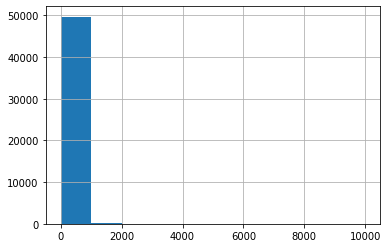

In [0]:
# Plotting the price distribution to assess if we have values to drop like those very high
df.price.hist()

 **Security deposit** <br>
Same in this case

In [0]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

**Cleaning fee** <br>
Same in this case

In [0]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

**Extra people** <br>
Same situation in this case, converting to integer and dropping the unnecessary elements of the string

In [0]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

**calendar updated, availability 30, availability 60, availability 365** <br>
Dropping some more columns

In [0]:
df.drop(['calendar_updated', 'availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

**First review** <br>


In [0]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 12, 29) - df.first_review).astype('timedelta64[D]')

Creating a binning function to rescale the data of the columns and create groups instead on numbers

In [0]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [0]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [0]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

In [0]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

Dropping the column now that we have done all the necessary operations on it

In [0]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

In [0]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])

In [0]:
variables_to_plot.pop(0)

'review_scores_rating'

In [0]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [0]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [0]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [0]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

Now doing a little bit of data visualization to understand if we have a regional influence on the price to get a first view of the dataset

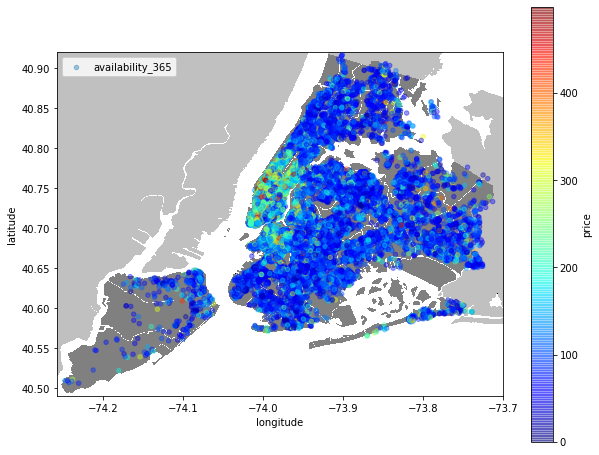

In [0]:
import urllib

lat_long2 = pd.merge(lat_long, df.price, left_index=True, right_index=True)


#initializing the figure size
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
#using scatterplot again
lat_long2[lat_long2.price<500].plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.show()

We clearly see that Lower Manhattan is a region where prices are relatively high. The Brooklyn area is also an area with high prices, for the rest of the areas, nothing particular to notice yet.

Looking at the number of hosts joining AirBnB and those getting a first review

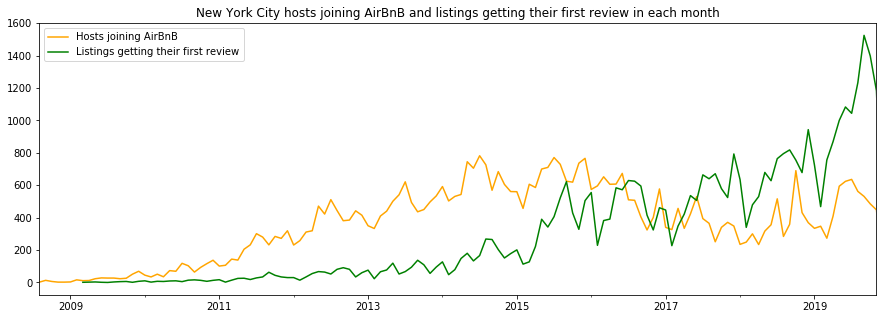

In [0]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining AirBnB', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('New York City hosts joining AirBnB and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-11-30')
plt.xlabel('')
plt.ylabel('')
plt.show()

Nightly prices 

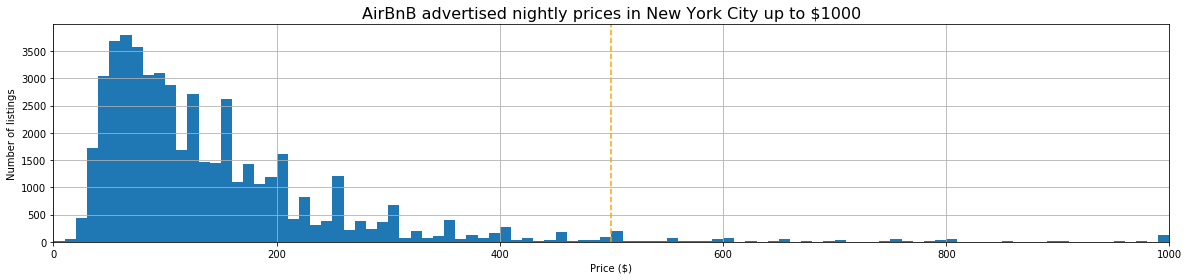

In [0]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.title("AirBnB advertised nightly prices in New York City up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

Median prices of listings according to the number of people being accomodated

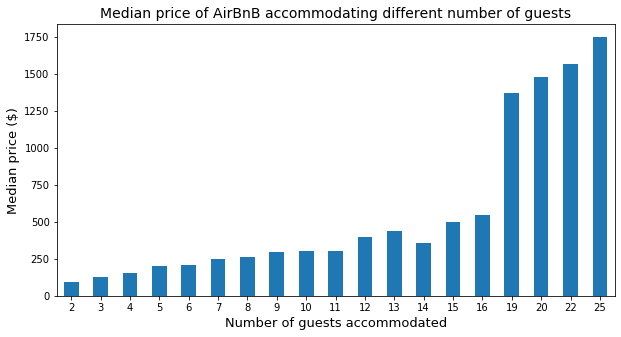

In [0]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of AirBnB accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

In [0]:
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

# Preparing data for modelling

In [0]:
transformed_df = pd.get_dummies(df[df.price<500])

In [0]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [0]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [0]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [0]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Creating a function to evaluate the performance of our different neural networks

In [0]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Linear regression

In [0]:
import statsmodels.api as sm

X1 = X_train.copy()
X1 = sm.add_constant(X1) ## let's add an intercept (beta_0) to our model
X1 = np.array(X1)

model = sm.OLS(y_train, X1).fit()
predictions = model.predict(X_test)

model.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     242.4
Date:                Thu, 09 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:15:53   Log-Likelihood:                -18034.
No. Observations:               39024   AIC:                         3.666e+04
Df Residuals:                   38729   BIC:                         3.919e+04
Df Model:                         294                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0102      0.002      4.131      0.000       0.005       0.015
x2            -0.0123      0.002     -5.073      0.000      -0.017      -0.008
x3            -0.0050      0.002     -2.184      0.029      -0.010      -0.001
x4             0.1822      0.003     67.116      0.000       0.177       0.187
x5             0.0200      0.002      9.566      0.000       0.016       0.024
x6             0.0131      0.002      5.857      0.000       0.009       0.017
x7             0.0130      0.002      5.481      0.000       0.008       0.018
x8            -0.0213      0.002     -9.445      0.000      -0.026      -0.017
x9            -0.0672      0.002    -28.785      0.000      -0.072      -0.063
x10           -0.0064      0.002     -3.093      0.002      -0.010      -0.002
x11            0.0577      0.003     23.066      0.000       0.053       0.063
x12           -0.0922      0.008    -11.714      0.000      -0.108      -0.077
x13            0.0077      0.002      3.577      0.000       0.003       0.012
x14            0.0180      0.003      6.960      0.000       0.013       0.023
x15            0.0148      0.002      7.017      0.000       0.011       0.019
x16           -0.0041      0.003     -1.643      0.100      -0.009       0.001
x17            0.0281      0.002     13.098      0.000       0.024       0.032
x18            0.0074      0.003      2.578      0.010       0.002       0.013
x19           -0.0092      0.003     -3.096      0.002      -0.015      -0.003
x20            0.0345      0.002     15.113      0.000       0.030       0.039
x21            0.0240      0.002      9.592      0.000       0.019       0.029
x22            0.0236      0.002      9.939      0.000       0.019       0.028
x23            0.0119      0.002      5.239      0.000       0.007       0.016
x24           -0.0074      0.003     -2.920      0.003      -0.012      -0.002
x25            0.0074      0.002      3.277      0.001       0.003       0.012
x26           -0.0076      0.002     -3.717      0.000      -0.012      -0.004
x27            0.0035      0.002      1.460      0.144      -0.001       0.008
x28            0.0028      0.002      1.369      0.171      -0.001       0.007
x29            0.0121      0.002      5.507      0.000       0.008       0.016
x30            0.0106      0.002      4.468      0.000       0.006       0.015
x31            0.0065      0.003      2.439      0.015       0.001       0.012
x32           -0.0008      0.007     -0.110      0.912      -0.014       0.013
x33            0.0055      0.002      2.238      0.025       0.001       0.010
x34         6.634e-05      0.003      0.020      0.984      -0.006       0.007
x35           -0.0043      0.004     -1.001      0.317      -0.013       0.004
x36            0.0063      0.011      0.576      0.565      -0.015       0.028
x3

In [0]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, predictions))
print(mean_squared_error(y_train, model.predict(X_train)))


2658184.5346343503
0.14754751448867012


In [0]:
print(r2_score(y_test, model.predict(X_test)))

# First model
XGBoost

In [0]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.4 minutes

Training MSE: 0.1531
Validation MSE: 0.1494

Training r2: 0.6346
Validation r2: 0.6373


In [0]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
host_is_superhost,0.000000
neighbourhood_cleansed_Morris Heights,0.000000
neighbourhood_cleansed_Morris Park,0.000000
neighbourhood_cleansed_Morrisania,0.000000
neighbourhood_cleansed_Mott Haven,0.000000
...,...
accommodates,0.021803
bathrooms,0.023676
elevator,0.023820
cleaning_fee,0.038347


In [0]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_short, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train_short)
val_preds_xgb_reg = xgb_reg.predict(X_test_short)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:50:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.4 minutes

Training MSE: 0.1536
Validation MSE: 0.1509

Training r2: 0.6334
Validation r2: 0.6334


# Second model
As we are doing a regression, the output layer will be with a linear activation function. We build a three-layer neural network to better 





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               38272     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 137,345
Trainable params: 137,345
Non-trainable params: 0
_________________________________________________________________
None


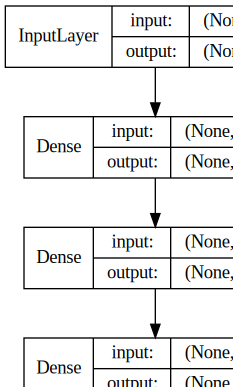

In [0]:
# Building the model
nn1 = models.Sequential()
nn1.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn1.add(layers.Dense(256, activation='relu'))
nn1.add(layers.Dense(256, activation='relu'))
nn1.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn1.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn1.summary())

# Visualising the neural network
SVG(model_to_dot(nn1, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn1_start = time.time()

nn1_history = nn1.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn1_end = time.time()

print(f"Time taken to run: {round((nn1_end - nn1_start)/60,1)} minutes")




Train on 35121 samples, validate on 3903 samples
Epoch 1/100





35121/35121 [==============================] - 1s 43us/step - loss: 1.8117 - mean_squared_error: 1.8117 - val_loss: 0.3092 - val_mean_squared_error: 0.3092
Epoch 2/100
35121/35121 [==============================] - 1s 28us/step - loss: 0.2290 - mean_squared_error: 0.2290 - val_loss: 0.2219 - val_mean_squared_error: 0.2219
Epoch 3/100
35121/35121 [==============================] - 1s 28us/step - loss: 0.1784 - mean_squared_error: 0.1784 - val_loss: 0.2068 - val_mean_squared_error: 0.2068
Epoch 4/100
35121/35121 [==============================] - 1s 27us/step - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.2003 - val_mean_squared_error: 0.2003
Epoch 5/100
35121/35121 [==============================] - 1s 28us/step - loss: 0.1477 - mean_squared_error: 0.1477 - val_loss: 0.1966 - val_mean_squared_error: 0.1966
Epoch 6/100
35121/35121 [==============================] - 1s 28us/step - loss: 0.1407 - mean_squared_e

Training MSE: 0.0384
Validation MSE: 0.2611

Training r2: 0.9084
Validation r2: 0.3659


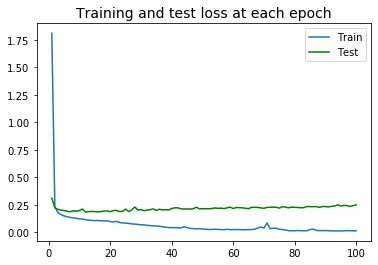

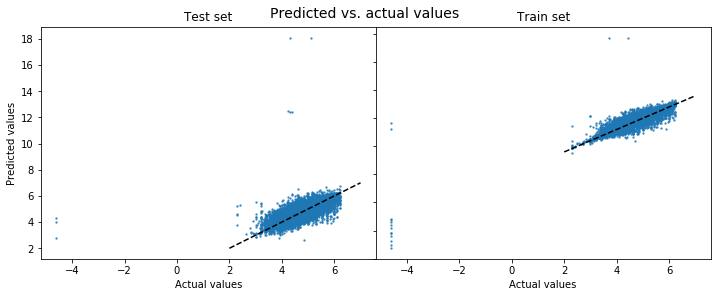

In [0]:
nn_model_evaluation(nn1)

# Third model
Adding another layer and making it a four-layer neural network <br>
We also added some regularization to avoid the overfitting we had in the previous model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               38272     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 269,185
Trainable params: 269,185
Non-trainable params: 0
_________________________________________________________________
None


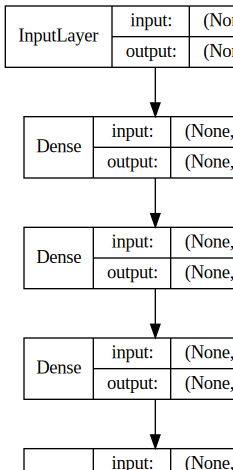

In [0]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 35121 samples, validate on 3903 samples
Epoch 1/150
35121/35121 [==============================] - 2s 57us/step - loss: 39.5861 - mean_squared_error: 1.6600 - val_loss: 17.5652 - val_mean_squared_error: 0.2274
Epoch 2/150
35121/35121 [==============================] - 2s 47us/step - loss: 10.3775 - mean_squared_error: 0.1896 - val_loss: 5.5542 - val_mean_squared_error: 0.1803
Epoch 3/150
35121/35121 [==============================] - 2s 47us/step - loss: 3.4476 - mean_squared_error: 0.1730 - val_loss: 2.0117 - val_mean_squared_error: 0.1920
Epoch 4/150
35121/35121 [==============================] - 2s 46us/step - loss: 1.3712 - mean_squared_error: 0.1804 - val_loss: 0.9466 - val_mean_squared_error: 0.1904
Epoch 5/150
35121/35121 [==============================] - 2s 47us/step - loss: 0.7370 - mean_squared_error: 0.1750 - val_loss: 0.5999 - val_mean_squared_error: 0.1774
Epoch 6/150
35121/35121 [==============================] - 2s 46us/step - loss: 0.5151 - mean_squared_error:

Training MSE: 0.1493
Validation MSE: 0.1438

Training r2: 0.6438
Validation r2: 0.6508


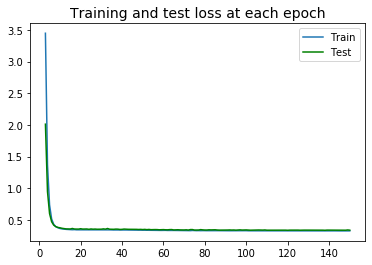

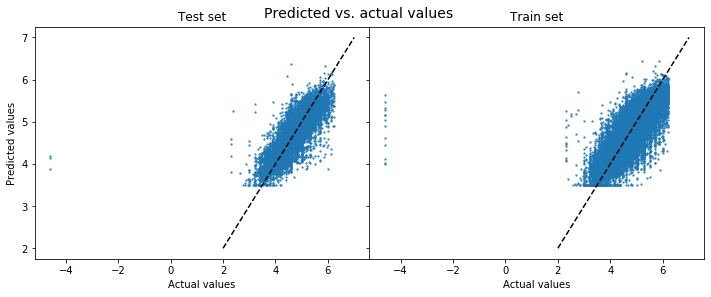

In [0]:
# Evaluating the model
nn_model_evaluation(nn2, skip_epochs=2)

## Fourth model


In [0]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               35968     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 266,881
Trainable params: 266,881
Non-trainable params: 0
_________________________________________________________________
None


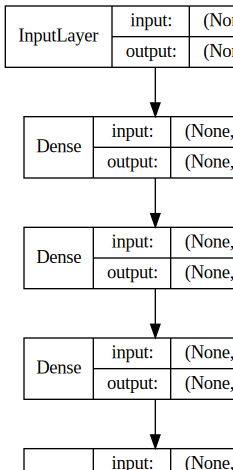

In [0]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train_short.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))


# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train_short,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split=0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")

Train on 35121 samples, validate on 3903 samples
Epoch 1/50
35121/35121 [==============================] - 2s 58us/step - loss: 40.8961 - mean_squared_error: 1.9114 - val_loss: 20.1772 - val_mean_squared_error: 0.2517
Epoch 2/50
35121/35121 [==============================] - 2s 45us/step - loss: 13.0054 - mean_squared_error: 0.1908 - val_loss: 7.8494 - val_mean_squared_error: 0.1803
Epoch 3/50
35121/35121 [==============================] - 2s 46us/step - loss: 5.2433 - mean_squared_error: 0.1729 - val_loss: 3.3279 - val_mean_squared_error: 0.1917
Epoch 4/50
35121/35121 [==============================] - 2s 45us/step - loss: 2.3251 - mean_squared_error: 0.1861 - val_loss: 1.5889 - val_mean_squared_error: 0.1972
Epoch 5/50
35121/35121 [==============================] - 2s 45us/step - loss: 1.1805 - mean_squared_error: 0.1799 - val_loss: 0.8875 - val_mean_squared_error: 0.1838
Epoch 6/50
35121/35121 [==============================] - 2s 45us/step - loss: 0.7131 - mean_squared_error: 0.165

Training MSE: 0.1527
Validation MSE: 0.1466

Training r2: 0.6356
Validation r2: 0.644


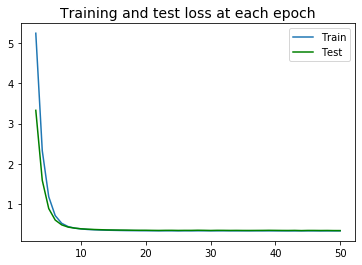

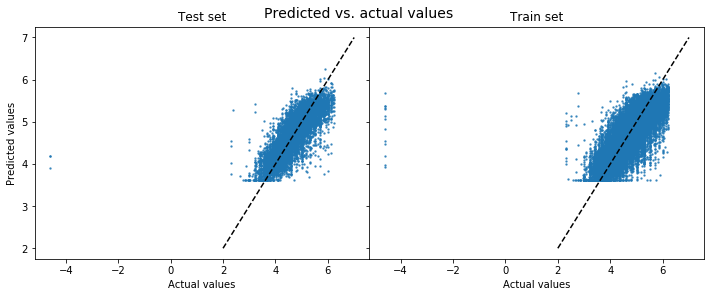

In [0]:
nn_model_evaluation(nn3, skip_epochs=2, X_train=X_train_short, X_test=X_test_short)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_11 (Dropout)         (None, 298)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               38272     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)              

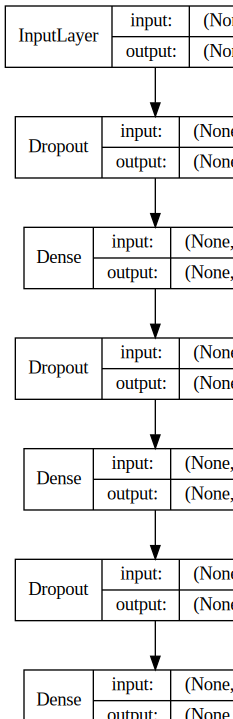

In [0]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn4.add(layers.Dense(128, activation='relu'))
nn4.add(layers.Dropout(0.5))
nn4.add(layers.Dense(256, activation='relu'))
nn4.add(layers.Dropout(0.5))
nn4.add(layers.Dense(512, activation='relu'))
nn4.add(layers.Dropout(0.5))
nn4.add(layers.Dense(1, activation='linear'))


# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Train on 35121 samples, validate on 3903 samples
Epoch 1/150
35121/35121 [==============================] - 3s 78us/step - loss: 5.1543 - mean_squared_error: 5.1543 - val_loss: 4.4744 - val_mean_squared_error: 4.4744
Epoch 2/150
35121/35121 [==============================] - 2s 54us/step - loss: 1.7902 - mean_squared_error: 1.7902 - val_loss: 4.3532 - val_mean_squared_error: 4.3532
Epoch 3/150
35121/35121 [==============================] - 2s 55us/step - loss: 1.2432 - mean_squared_error: 1.2432 - val_loss: 4.0681 - val_mean_squared_error: 4.0681
Epoch 4/150
35121/35121 [==============================] - 2s 54us/step - loss: 0.9776 - mean_squared_error: 0.9776 - val_loss: 3.5174 - val_mean_squared_error: 3.5174
Epoch 5/150
35121/35121 [==============================] - 2s 54us/step - loss: 0.8848 - mean_squared_error: 0.8848 - val_loss: 3.1020 - val_mean_squared_error: 3.1020
Epoch 6/150
35121/35121 [==============================] - 2s 54us/step - loss: 0.7156 - mean_squared_error: 0.

Training MSE: 0.173
Validation MSE: 0.1699

Training r2: 0.5873
Validation r2: 0.5873


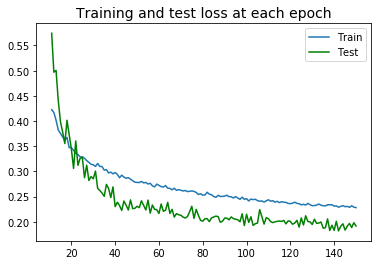

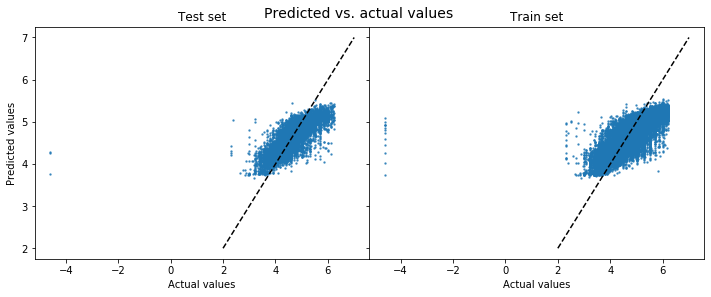

In [0]:
nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models